In [116]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd
from pandas import DataFrame, Series
import logging
import time

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sns.set(style="ticks")
tf.logging.set_verbosity(logging.ERROR)

## Facebook Comment Volume Predictions: Neural Networks and Decision Trees

Our goal is to reproduce the work completed in the following paper:

> Singh, Kamaljot, R. K. Sandhu, and Dinesh Kumar. "Comment volume prediction using neural networks and decision trees." IEEE UKSim-AMSS 17th International Conference on Computer Modelling and Simulation, UKSim2015 (UKSim2015), Cambridge, United Kingdom. 2015.

In this work, they scraped Facebook pages for an array of features and built models to predict the comment volume on these pages after different intervals of time. The specifics of the data extraction and feature engineering are not the key piece of interest here but instead what they did next. They trained various decision tree and neural network models and compared them across several performance metrics. The hypothesis of this work is that although deep networks achieve a large amount of notoriety, that their added complexity is not often justified (in terms of performance and training times).

In this paper a Java implementation was used with the following models:
- MLP (4)
- MLP (20, 4)
- REP Tree
- M5P Tree
- RBF Network (90 clusters)

Since we would like to stay in our Python stack of SciKit-Learn and Tensorflow, the following comparable models were chosen:
- MLP (4)
- MLP (20, 4)
- Decision Tree
- Random Forest
- Extra Trees
- Adaboost

### Data Preparation

Multiple training set variants were provided. Each variant is numbered by the number of points extracted from each Facebook page. For instance, Variant 2 has two data points per Facebook pages at taken at random intervals.

In [ ]:
training_variants = {n: pd.read_csv(('datasets/facebook/Training/Features_Variant_%s.csv' % n), header=None) 
                     for n in range(1,6)}

The test cases were built by evaluating the comment volume at 100 time intervals for 10 different pages.

In [74]:
test_cases = {n: pd.read_csv(('datasets/facebook/Testing/TestSet/Test_Case_%s.csv' % n), header=None) 
                     for n in range(1,11)}

We use a simple scaler to transform our data. This scaler will be reused for all test and training sets.

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

X = training_variants[1].iloc[:,:-1].values
y = training_variants[1].iloc[:, -1].values
pipeline.fit(X)

Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])

### Decision Tree Training

For the decision tree based models, a randomized cross validation search is used for tuning. Models were tuned to minimize Mean Absolute Error.

In [76]:
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform, expon, randint

def random_search_tuner(X, y, clf, params, scoring, cv=3, n_iter=500):

    random_search = RandomizedSearchCV(clf, params, cv=cv, scoring=scoring, 
                                       n_jobs=-1, verbose=1, n_iter=n_iter)
    random_search.fit(X, y)
    print("Best params: %s" % random_search.best_params_)
    print("Train score: %s" % random_search.best_score_)
    
    return random_search

In [77]:
def train_model_with_variants(model, preparation_pipeline, training_variants, params, n_iter=50):
    variant_models = {}
    for training_variant_name, training_variant in training_variants.items():
        X_train = training_variant.iloc[:,:-1].values
        X_train_transformed = preparation_pipeline.transform(X_train)
        y_train = training_variant.iloc[:, -1].values

        random_search = random_search_tuner(X_train_transformed, y_train, 
                                            model, params, 
                                            scoring='neg_mean_absolute_error', n_iter=n_iter)
        variant_models[training_variant_name] = random_search
    return variant_models

In [78]:
from sklearn.tree import DecisionTreeRegressor

params = {'max_depth': randint(2, 5),
        'min_samples_leaf': randint(200, 500),
        'min_samples_split': randint(400, 1500),
        'max_leaf_nodes': randint(2, 40)}

dtree_variant_models = train_model_with_variants(DecisionTreeRegressor(), pipeline, training_variants, params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    5.9s finished


Best params: {'max_depth': 4, 'max_leaf_nodes': 34, 'min_samples_leaf': 225, 'min_samples_split': 707}
Train score: -5.7462653418
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   11.0s finished


Best params: {'max_depth': 4, 'max_leaf_nodes': 29, 'min_samples_leaf': 317, 'min_samples_split': 740}
Train score: -5.54340323253
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   16.5s finished


Best params: {'max_depth': 4, 'max_leaf_nodes': 34, 'min_samples_leaf': 274, 'min_samples_split': 427}
Train score: -5.09301922402
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   22.4s finished


Best params: {'max_depth': 4, 'max_leaf_nodes': 18, 'min_samples_leaf': 238, 'min_samples_split': 765}
Train score: -5.02228121119
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   27.7s finished


Best params: {'max_depth': 4, 'max_leaf_nodes': 33, 'min_samples_leaf': 300, 'min_samples_split': 426}
Train score: -5.05635269827


In [79]:
from sklearn.ensemble import RandomForestRegressor

params = {'max_depth': randint(2, 5),
        'min_samples_leaf': randint(200, 500),
        'min_samples_split': randint(400, 1500),
        'max_leaf_nodes': randint(2, 40),
        'n_estimators': randint(5, 40)}

rf_variant_models = train_model_with_variants(RandomForestRegressor(), pipeline, training_variants, params, n_iter=30)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   23.1s finished


Best params: {'max_depth': 4, 'max_leaf_nodes': 27, 'min_samples_leaf': 309, 'min_samples_split': 601, 'n_estimators': 12}
Train score: -5.78470734272
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   48.7s finished


Best params: {'max_depth': 4, 'max_leaf_nodes': 36, 'min_samples_leaf': 389, 'min_samples_split': 666, 'n_estimators': 20}
Train score: -5.55961022119
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.4min finished


Best params: {'max_depth': 4, 'max_leaf_nodes': 14, 'min_samples_leaf': 238, 'min_samples_split': 436, 'n_estimators': 37}
Train score: -4.83265021153
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.8min finished


Best params: {'max_depth': 4, 'max_leaf_nodes': 26, 'min_samples_leaf': 269, 'min_samples_split': 628, 'n_estimators': 28}
Train score: -4.7139450799
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.6min finished


Best params: {'max_depth': 4, 'max_leaf_nodes': 24, 'min_samples_leaf': 255, 'min_samples_split': 815, 'n_estimators': 16}
Train score: -4.77435163114


In [80]:
from sklearn.ensemble import ExtraTreesRegressor

params = {'max_depth': randint(2, 5),
        'min_samples_leaf': randint(200, 500),
        'min_samples_split': randint(400, 1500),
        'max_leaf_nodes': randint(2, 40),
        'n_estimators': randint(5, 40)}

etree_variant_models = train_model_with_variants(ExtraTreesRegressor(), pipeline, training_variants, params, n_iter=30)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.5s finished


Best params: {'max_depth': 4, 'max_leaf_nodes': 15, 'min_samples_leaf': 209, 'min_samples_split': 1199, 'n_estimators': 37}
Train score: -6.16574728885
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   44.7s finished


Best params: {'max_depth': 4, 'max_leaf_nodes': 19, 'min_samples_leaf': 220, 'min_samples_split': 841, 'n_estimators': 32}
Train score: -5.76269333667
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.4min finished


Best params: {'max_depth': 4, 'max_leaf_nodes': 16, 'min_samples_leaf': 247, 'min_samples_split': 928, 'n_estimators': 36}
Train score: -5.47258101473
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.0min finished


Best params: {'max_depth': 4, 'max_leaf_nodes': 29, 'min_samples_leaf': 226, 'min_samples_split': 944, 'n_estimators': 23}
Train score: -5.32226651857
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.1min finished


Best params: {'max_depth': 4, 'max_leaf_nodes': 18, 'min_samples_leaf': 200, 'min_samples_split': 1131, 'n_estimators': 6}
Train score: -5.34964565646


In [81]:
from sklearn.ensemble import AdaBoostRegressor

params = {'learning_rate': uniform(.1, 3),
        'n_estimators': randint(10, 150)}

aboost_variant_models = train_model_with_variants(AdaBoostRegressor(), pipeline, training_variants, params, n_iter=30)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished


Best params: {'learning_rate': 0.12116488690224228, 'n_estimators': 52}
Train score: -8.29020954569
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.1min finished


Best params: {'learning_rate': 0.27005755272906173, 'n_estimators': 26}
Train score: -8.67290314933
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.8min finished


Best params: {'learning_rate': 0.18239177793792108, 'n_estimators': 15}
Train score: -7.56471957559
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.0min finished


Best params: {'learning_rate': 0.25855578039958715, 'n_estimators': 139}
Train score: -11.8561514665
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.4min finished


Best params: {'learning_rate': 0.11435933645156662, 'n_estimators': 118}
Train score: -10.2821260424


### Neural Network Training
Our NNs are built using high level Tensorflow APIs that are compatable with Scikit Learn estimators. This lets us use the same evaluation functions between our Scikit Learn Decision Tree and Tensorflow NN models.

In [132]:
def tf_train_model_with_variants(params, preparation_pipeline, training_variants):
    variant_models = {}
    variant_training_times = {}
    for training_variant_name, training_variant in training_variants.items():
        X_train = training_variant.iloc[:,:-1].values
        X_train_transformed = preparation_pipeline.transform(X_train)
        y_train = training_variant.iloc[:, -1].values
        
        start_time = time.time()
        model = tf.contrib.learn.DNNRegressor(**params)
        model.fit(x=X_train_transformed, y=y_train, batch_size=25, steps=20000)
        variant_models[training_variant_name] = model
        variant_training_times[training_variant_name] = time.time() - start_time
    return variant_models, variant_training_times

In [133]:
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X)

params = {'hidden_units': [20, 4], 'feature_columns': feature_columns}
dnn_20_4_variant_models, dnn_20_4_variant_times = tf_train_model_with_variants(params, pipeline, training_variants)

In [134]:
params = {'hidden_units': [4], 'feature_columns': feature_columns}
dnn_4_variant_models, dnn_4_variant_times = tf_train_model_with_variants(params, pipeline, training_variants)

### Evaluation

Four metrics were used to evaluate our models:
- Hits@10: This is the number of posts correctly predicted to be in the top 10 by comment volume
- AUC@10: This is the AUC based on a Top10 classification
- MAE: Mean absolute error
- Training time: Time taken to train a single instance of the model

In [135]:
def top_hits(y_test, y_pred, top_n=10):
    top_pred = set(np.flip(np.argsort(y_pred), 0)[:top_n])
    top_test = set(np.flip(np.argsort(y_test), 0)[:top_n])
    return len(top_pred.intersection(top_test))

In [136]:
from sklearn.metrics import roc_auc_score

def top_hits_auc(y_test, y_pred, top_n=3):
    top_pred = np.flip(np.argsort(y_pred), 0)[:top_n]
    top_test = np.flip(np.argsort(y_test), 0)[:top_n]

    pred_top_hits = np.zeros(len(y_test))
    pred_top_hits[top_pred] = 1
    
    test_top_hits = np.zeros(len(y_test))
    test_top_hits[top_test] = 1
    
    return roc_auc_score(test_top_hits, pred_top_hits)

In [137]:
def train_time_variants(models):
    train_times = []
    for name, model_variants in models.items():
        for variant, model in model_variants.items():
            train_times.append(Series({'model': name, 
                                                   'variant': variant,
                                                   'metric': 'train_time',
                                                   'value': model.cv_results_['mean_fit_time'].mean()}))
    return pd.concat(train_times, axis=1).T

We can now evaluate our saved model per variant on the above metrics. We will collect all of these evaluations in a DataFrame for easy plotting.

In [138]:
from sklearn.metrics import mean_absolute_error

def eval_test_cases(models, test_cases, evaluators):
    evaluations = []
    for name, model_variants in models.items():
        for variant, model in model_variants.items():
            for test_case_name, test_case in test_cases.items():
                X_test = test_case.iloc[:,:-1].values
                X_test_transformed = pipeline.transform(X_test)
                y_test = test_case.iloc[:, -1].values

                y_pred = np.array(list(model.predict(X_test_transformed)))
                for evaluator_name, evaluator in evaluators.items():
                    score = evaluator(y_test, y_pred)
                    evaluations.append(Series({'model': name, 
                                               'variant': variant,
                                               'metric': evaluator_name,
                                               'test_case': test_case_name,
                                               'value': score}))
    return pd.concat(evaluations, axis=1).T

sklearn_models = ('dtree', 'random_forest', 'extra_trees', 'adaboost')
tf_models = ('dnn_20_4', 'dnn_4')
models = {'dtree': dtree_variant_models, 
          'random_forest': rf_variant_models,
          'extra_trees': etree_variant_models,
          'adaboost': aboost_variant_models,
          'dnn_20_4': dnn_20_4_variant_models,
          'dnn_4': dnn_4_variant_models}
evaluators = {'Hit@10': top_hits,
              'AUC@10': top_hits_auc,
              'MAE': mean_absolute_error}
model_performance_metrics = eval_test_cases(models, test_cases, evaluators)

In [139]:
sklearn_model_training_metrics = train_time_variants({m: models[m] for m in sklearn_models})

In [140]:
tf_model_training_metrics_series = []
for variant, t in dnn_20_4_variant_times.items():
    tf_model_training_metrics_series.append(Series({'model': 'dnn_20_4', 
                                                    'variant': variant, 
                                                    'metric': 'train_time', 
                                                    'value': t}))
for variant, t in dnn_4_variant_times.items():
    tf_model_training_metrics_series.append(Series({'model': 'dnn_4', 
                                                    'variant': variant, 
                                                    'metric': 'train_time', 
                                                    'value': t}))
tf_model_training_metrics = pd.concat(tf_model_training_metrics_series, axis=1).T

In [141]:
model_metrics = pd.concat([model_performance_metrics, sklearn_model_training_metrics, tf_model_training_metrics])
model_metrics.head(10)

,metric,model,test_case,value,variant
0,Hit@10,dtree,1,7,1
1,AUC@10,dtree,1,0.656357,1
2,MAE,dtree,1,23.2499,1
3,Hit@10,dtree,2,6,1
4,AUC@10,dtree,2,0.656357,1
5,MAE,dtree,2,23.531,1
6,Hit@10,dtree,3,6,1
7,AUC@10,dtree,3,0.656357,1
8,MAE,dtree,3,21.8966,1
9,Hit@10,dtree,4,6,1


In [142]:
def metric_variant_plot(model_metrics, metric):
    sns.factorplot(x='model', y='value', hue='variant', 
                   data=model_metrics[model_metrics['metric']==metric], 
                   kind='bar', palette='muted', size=8)
    plt.title(metric)

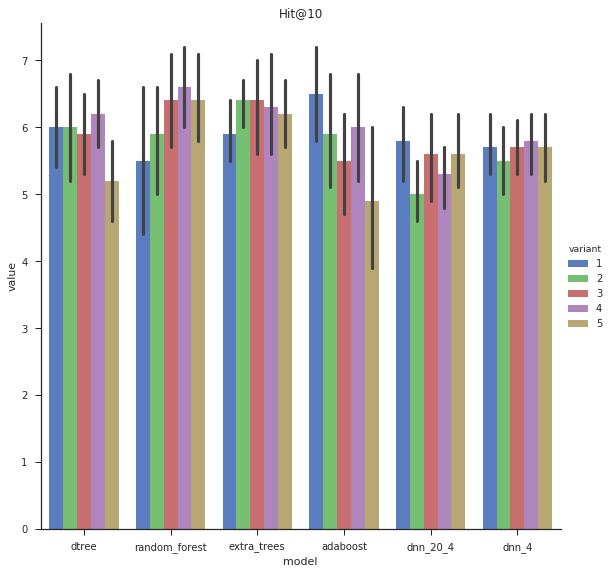

In [143]:
metric_variant_plot(model_metrics, 'Hit@10')

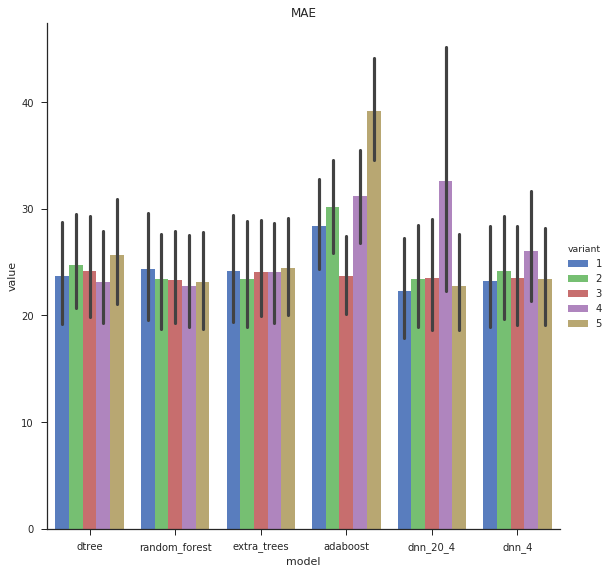

In [144]:
metric_variant_plot(model_metrics, 'MAE')

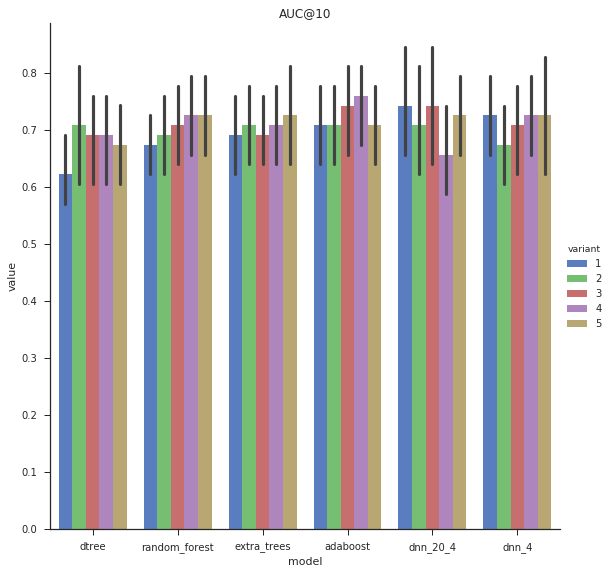

In [145]:
metric_variant_plot(model_metrics, 'AUC@10')

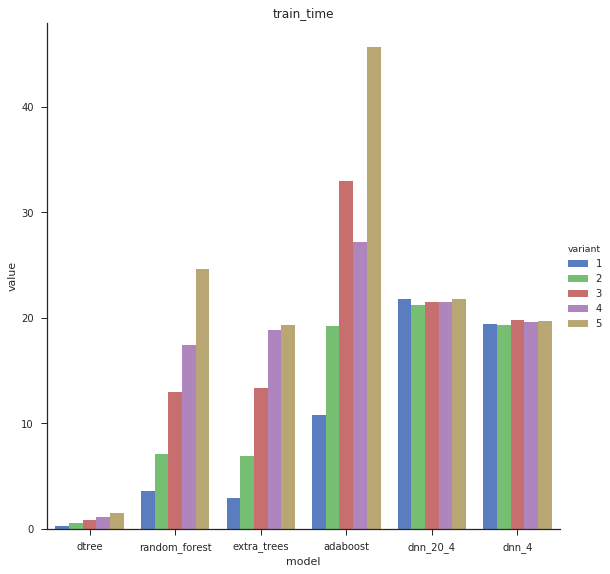

In [146]:
metric_variant_plot(model_metrics, 'train_time')

### Conclusions
Overall, we see very similiar performance metrics across models and variants. Training time for some of the decision tree models scale very poorly with the increase in training set size, although there did not seem to be much extra performance provided by these larger datasets either.

This leads us to follow the rule of thumb:
> Start simple, and only add complexity if the simple solution did not suffice.